In [26]:
import pandas as pd
import numpy as np
import requests
import io
import time
import json
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import statistics
import cartopy.geodesic as cgeo
import json


# Haversine formula for calculating the distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Vectorizing the Haversine formula
vec_haversine = np.vectorize(haversine)


In [2]:
BLITZ_DIST = 100

lat=50.
lon=9.

sitename = 'Frankfurt am Main'


In [7]:
json_file = '/home/kakl/vanice/data/fr_wind-turbines.geojson'

with open(json_file) as f:
    data = json.load(f)
windturbines = pd.json_normalize(data,'features')

windturbines['lon'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
windturbines['lat'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [8]:
# Reduction of wind-turbines points

windturbines['lonRad']=np.radians(windturbines.lon)
windturbines['latRad']=np.radians(windturbines.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
windturbines['DlonRad']=lonRad-windturbines.lonRad
windturbines['DlatRad']=latRad-windturbines.latRad
windturbines['a']=np.sin(windturbines.DlatRad/2.)**2. + np.cos(windturbines.latRad) * np.cos(latRad) * np.sin(windturbines.DlonRad/2.)**2.
windturbines['km'] = 2. * np.arcsin(np.sqrt(windturbines.a))*6378.
windturbines = windturbines.loc[windturbines['km'] <= BLITZ_DIST]
windturbines.reset_index(inplace=True)

In [72]:
json_file = '/home/kakl/vanice/data/fr_towers.geojson'

with open(json_file) as f:
    data = json.load(f)
towers = pd.json_normalize(data,'features')

towers['lon'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
towers['lat'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [73]:
# Reduction of distant tall structures

towers['lonRad']=np.radians(towers.lon)
towers['latRad']=np.radians(towers.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
towers['DlonRad']=lonRad-towers.lonRad
towers['DlatRad']=latRad-towers.latRad
towers['a']=np.sin(towers.DlatRad/2.)**2. + np.cos(towers.latRad) * np.cos(latRad) * np.sin(towers.DlonRad/2.)**2.
towers['km'] = 2. * np.arcsin(np.sqrt(towers.a))*6378.
towers = towers.loc[towers['km'] <= BLITZ_DIST]


In [74]:
json_file = '/home/kakl/vanice/data/fr_masts.geojson'

with open(json_file) as f:
    data = json.load(f)
masts = pd.json_normalize(data,'features')

masts['lon'] = masts['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
masts['lat'] = masts['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [75]:
# Reduction of distant tall structures

masts['lonRad']=np.radians(masts.lon)
masts['latRad']=np.radians(masts.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
masts['DlonRad']=lonRad-masts.lonRad
masts['DlatRad']=latRad-masts.latRad
masts['a']=np.sin(masts.DlatRad/2.)**2. + np.cos(masts.latRad) * np.cos(latRad) * np.sin(masts.DlonRad/2.)**2.
masts['km'] = 2. * np.arcsin(np.sqrt(masts.a))*6378.
masts = masts.loc[masts['km'] <= BLITZ_DIST]


In [11]:
json_file = '/home/kakl/vanice/data/tall.geojson'

# Rekurzivní funkce pro získání prvního ne-pole prvku
def vyber_prvni_nevnoreny_prvek(hodnota):
    if isinstance(hodnota, list):
        # Pokud je první prvek listu další list, pokračujeme rekurzivně
        return vyber_prvni_nevnoreny_prvek(hodnota[0])
    else:
        # Vrátíme první prvek, který není list
        return hodnota

# Rekurzivní funkce pro nalezení posledního vnořeného pole
def najdi_posledni_vnorene_pole(pole):
    if not isinstance(pole, list) or not pole:
        return None
    if all(not isinstance(item, list) for item in pole):
        return pole  # Vrátí pole, pokud žádný prvek není další seznam
    for item in reversed(pole):
        if isinstance(item, list):
            return najdi_posledni_vnorene_pole(item)  # Rekurzivní hledání v posledním vnořeném seznamu

# Funkce pro získání druhého prvku z posledního vnořeného pole
def vyber_druhy_prvek_posledniho_vnoreneho_pole(hodnota):
    posledni_vnorene_pole = najdi_posledni_vnorene_pole(hodnota)
    if posledni_vnorene_pole and len(posledni_vnorene_pole) >= 2:
        return posledni_vnorene_pole[1]  # Vrátí druhý prvek, pokud je dostupný
    return None

# Funkce pro získání druhého prvku z posledního vnořeného pole
def vyber_prvni_prvek_posledniho_vnoreneho_pole(hodnota):
    posledni_vnorene_pole = najdi_posledni_vnorene_pole(hodnota)
    if posledni_vnorene_pole and len(posledni_vnorene_pole) >= 2:
        return posledni_vnorene_pole[0]  # Vrátí druhý prvek, pokud je dostupný
    return None


with open(json_file) as f:
    data = json.load(f)
buildings = pd.json_normalize(data,'features')

# Vytvoříme nový sloupec 'prvni_prvek' obsahující pouze první prvek z každého pole v 'sloupec_s_polem'
#buildings['coordinates'] =  buildings['geometry.coordinates'].apply(lambda x: x[0] if x else None)
#buildings['coordinates'] =  buildings['coordinates'].apply(lambda x: x[0] if x else None)
buildings['lon'] = buildings['geometry.coordinates'].apply(vyber_prvni_prvek_posledniho_vnoreneho_pole)
buildings['lat'] = buildings['geometry.coordinates'].apply(vyber_druhy_prvek_posledniho_vnoreneho_pole)


In [12]:
# Reduction of building points

buildings['lonRad']=np.radians(buildings.lon)
buildings['latRad']=np.radians(buildings.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
buildings['DlonRad']=lonRad-buildings.lonRad
buildings['DlatRad']=latRad-buildings.latRad
buildings['a']=np.sin(buildings.DlatRad/2.)**2. + np.cos(buildings.latRad) * np.cos(latRad) * np.sin(buildings.DlonRad/2.)**2.
buildings['km'] = 2. * np.arcsin(np.sqrt(buildings.a))*6378.
buildings = buildings.loc[buildings['km'] <= BLITZ_DIST]
buildings.reset_index(inplace=True)

buildings = buildings.drop_duplicates(subset='lon')

In [13]:
json_file = '/home/kakl/vanice/data/fr_chimneys.geojson'

with open(json_file) as f:
    data = json.load(f)
chimneys = pd.json_normalize(data,'features')

chimneys['lon'] = chimneys['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
chimneys['lat'] = chimneys['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [14]:
# Reduction of distant tall structures

chimneys['lonRad']=np.radians(chimneys.lon)
chimneys['latRad']=np.radians(chimneys.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
chimneys['DlonRad']=lonRad-chimneys.lonRad
chimneys['DlatRad']=latRad-chimneys.latRad
chimneys['a']=np.sin(chimneys.DlatRad/2.)**2. + np.cos(chimneys.latRad) * np.cos(latRad) * np.sin(chimneys.DlonRad/2.)**2.
chimneys['km'] = 2. * np.arcsin(np.sqrt(chimneys.a))*6378.
chimneys = chimneys.loc[chimneys['km'] <= BLITZ_DIST]


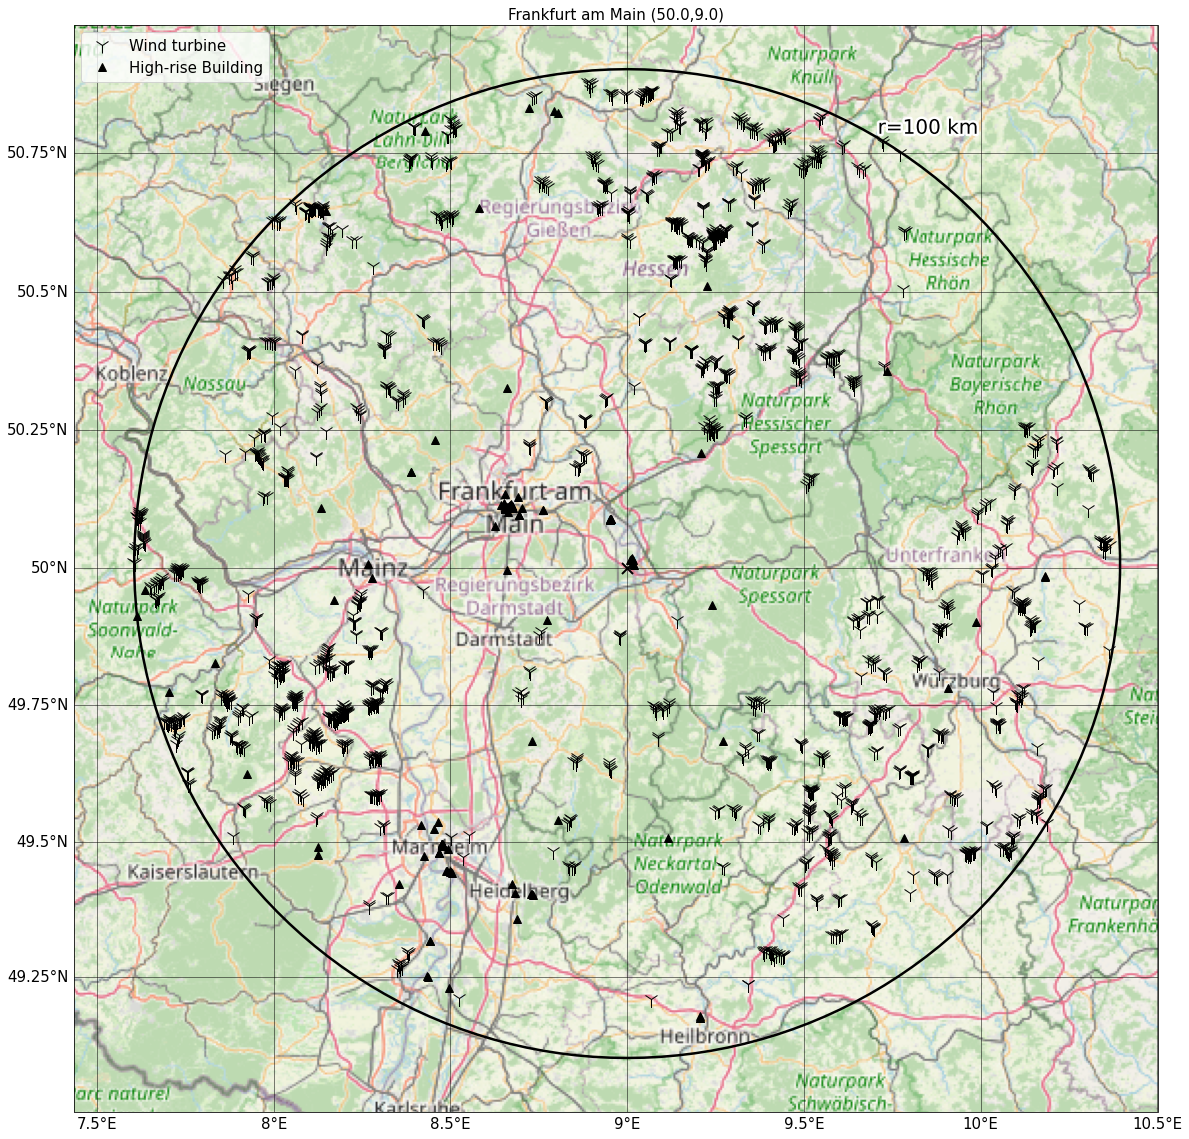

In [394]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    RADIUS = BLITZ_DIST * 1000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    scale = 8
    
    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=11, mew=2, transform=data_crs)
    
    ax.plot(windturbines.lon,windturbines.lat,color='black',lw=0,marker='1',ms=15,mew=1.0,transform=data_crs, label='Wind turbine')
    #ax.plot(towers.lon,towers.lat,color='red',lw=0,marker='|',ms=7,mew=1.0,transform=data_crs, label='Tower')
    #ax.plot(masts.lon,masts.lat,color='orange',lw=0,marker='|',ms=7,mew=1.0,transform=data_crs, label='Mast')
    #ax.plot(chimneys.lon,chimneys.lat,color='chocolate',lw=0,marker='.',ms=10,mew=1.0,transform=data_crs, label='Chimney')
    ax.plot(buildings.lon,buildings.lat,color='black',lw=0,marker='^',ms=8,mew=1.0,transform=data_crs, label='High-rise Building')
    #ax.plot(chimneys.lon,chimneys.lat,color='green',lw=0,marker='.',ms=10,mew=1.0,transform=data_crs, label='chimney')

    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={int(radius/1000)} km', color='black', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    
    plt.legend(loc=2)

    plt.show()

    fig.savefig(f'./pics/map.png', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":
   main()

In [252]:
print('windturbnes', len(windturbines))
print('High-rise buildings', len(buildings))
print('Towers', len(towers))
print('Masts', len(masts))
print('Chimneys', len(chimneys))


windturbnes 1747
High-rise buildings 143
Towers 3753
Masts 3191
Chimneys 440


In [24]:
buildings[buildings.duplicated(['lon'], keep=False)]

Empty DataFrame
Columns: [index, type, id, properties.@id, properties.addr:city, properties.addr:housenumber, properties.addr:postcode, properties.addr:street, properties.building, properties.building:cladding, properties.building:facade:material, properties.building:levels, properties.building:levels:underground, properties.building:roof, properties.building:use, properties.height, properties.name, properties.roof:shape, properties.start_date, properties.wikidata, properties.wikimedia_commons, properties.wikipedia, geometry.type, geometry.coordinates, properties.addr:country, properties.addr:housename, properties.alt_name, properties.building:part, properties.operator, properties.building:colour, properties.official_name, properties.short_name, properties.building:material, properties.name:en, properties.name:ja, properties.seamark:landmark:conspicuity, properties.seamark:landmark:name, properties.seamark:type, properties.source, properties.wheelchair, properties.TMC:cid_58:tabcd_1:Class, properties.TMC:cid_58:tabcd_1:LCLversion, properties.TMC:cid_58:tabcd_1:LocationCode, properties.man_made, properties.roof:colour, properties.roof:height, properties.amenity, properties.architect, properties.architect:wikidata, properties.building:architecture, properties.deanery, properties.denomination, properties.diocese, properties.fixme, properties.heritage, properties.heritage:operator, properties.parish, properties.religion, properties.roof:material, properties.source:heritage, properties.toilets:wheelchair, properties.website, properties.tower:type, properties.communication:microwave, properties.communication:mobile_phone, properties.communication:radio, properties.communication:television, properties.tower:construction, properties.source:height, properties.name:shs, properties.source:geometry, properties.access, properties.material, properties.name2, properties.operator:MNC, properties.ref, properties.note, properties.office, properties.disused, properties.communication:noeml, properties.communication:bos, properties.communication:tetra, properties.operator:short, properties.ele, properties.layer, properties.model, properties.technology, properties.addr:suburb, properties.communication:bos:tetra, properties.description, properties.direction, properties.fee, properties.step_count, properties.tourism, properties.owner, properties.old_name, properties.designation, properties.reg_name, properties.seamark:landmark:category, properties.demolished:building, ...]
Index: []

[0 rows x 191 columns]

In [76]:
ble
start=pd.Timestamp('2021-1-1') 

# Converting pandas.Series to numpy.array
latRad_windturbines = windturbines['latRad'].to_numpy()
lonRad_windturbines = windturbines['lonRad'].to_numpy()
latRad_towers = towers['latRad'].to_numpy()
lonRad_towers = towers['lonRad'].to_numpy()
latRad_chimneys = chimneys['latRad'].to_numpy()
lonRad_chimneys = chimneys['lonRad'].to_numpy()
latRad_buildings = buildings['latRad'].to_numpy()
lonRad_buildings = buildings['lonRad'].to_numpy()

medians = pd.DataFrame(columns=['day', 'median'])

#for d in range(0,60):
for d in range(0,365*3+160):
    day = start + pd.Timedelta(days=d)
    ifile = '%02d-%02d-%02d.log' % (day.year, day.month, day.day)

    # Load of lightning data
    blitz = pd.read_csv('/storage/blitzortung/2021-2023/region-1/'+ifile, sep=',', low_memory=False, on_bad_lines='skip')
    print(ifile)

    # Reduction of distant lightnings
    blitz['lonRad']=np.radians(blitz.lon)
    blitz['latRad']=np.radians(blitz.lat)
    lonRad=np.radians(lon)
    latRad=np.radians(lat)
    blitz['DlonRad']=lonRad-blitz.lonRad
    blitz['DlatRad']=latRad-blitz.latRad
    blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
    blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
    blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
    blitz.reset_index(inplace=True)

    if len(blitz)>0:
        # Identify lightning with nearby structures

        # Converting coordinates to radians
        blitz['latRad'] = np.radians(blitz['lat'])
        blitz['lonRad'] = np.radians(blitz['lon'])
        #windturbines['latRad'] = np.radians(windturbines['lat'])
        #windturbines['lonRad'] = np.radians(windturbines['lon'])

        # Converting pandas.Series to numpy.array
        latRad_blitz = blitz['latRad'].to_numpy()
        lonRad_blitz = blitz['lonRad'].to_numpy()
        #latRad_windturbines = windturbines['latRad'].to_numpy()
        #lonRad_windturbines = windturbines['lonRad'].to_numpy()

        # Calculating distance between each point in 'blitz' and all points in 'structures'
        distances_wt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_windturbines, lonRad_windturbines)
        distances_tw = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_towers, lonRad_towers)
        distances_ch = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_chimneys, lonRad_chimneys)
        distances_bu = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_buildings, lonRad_buildings)

        median_wt = round(statistics.median(np.amin(distances_wt, axis=1)),1)
        median_tw = round(statistics.median(np.amin(distances_tw, axis=1)),1)
        median_ch = round(statistics.median(np.amin(distances_ch, axis=1)),1)
        median_bu = round(statistics.median(np.amin(distances_bu, axis=1)),1)
    else:
        median_wt = np.nan
        median_tw = np.nan
        median_ch = np.nan
        median_bu = np.nan
    strokes = len(blitz)
    print(strokes, median_wt, median_tw, median_ch, median_bu)
    #print(strokes, median_wt, median_bu)
    median = pd.DataFrame(data= {'day':[day],'median_wt':[median_wt],'median_tw':[median_tw],'median_ch':[median_ch],'median_bu':[median_bu],'strokes':[strokes]})
    #median = pd.DataFrame(data= {'day':[day],'median_wt':[median_wt],'median_bu':[median_bu],'strokes':[strokes]})
    medians = pd.concat([medians,median])
    

NameError: name 'ble' is not defined

In [36]:
medians = pd.read_csv('medians_2021-2024.csv')
medians['day'] = pd.to_datetime(medians['day'])
medians.set_index('day', inplace=True, drop=False)

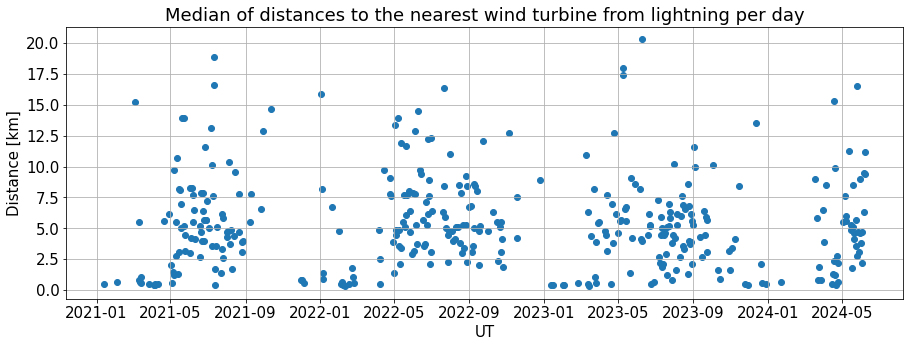

In [37]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_wt'])
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

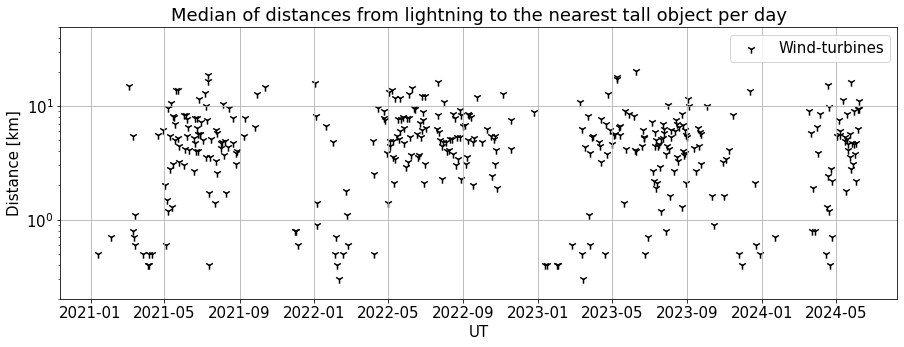

In [66]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_wt'], marker='1', color='black', s=70, label='Wind-turbines')
#plt.scatter(medians['day'],medians['median_bu'], marker='^', color='red', s=20, label='High-raising buildings')
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.ylim(0.2, 50)
plt.legend(loc=1)
plt.title('Median of distances from lightning to the nearest tall objects per day')
plt.grid()

plt.savefig("/home/kakl/vanice/pics/fig_medians_wt.png", format="png", dpi=600, bbox_inches="tight")   
plt.show()


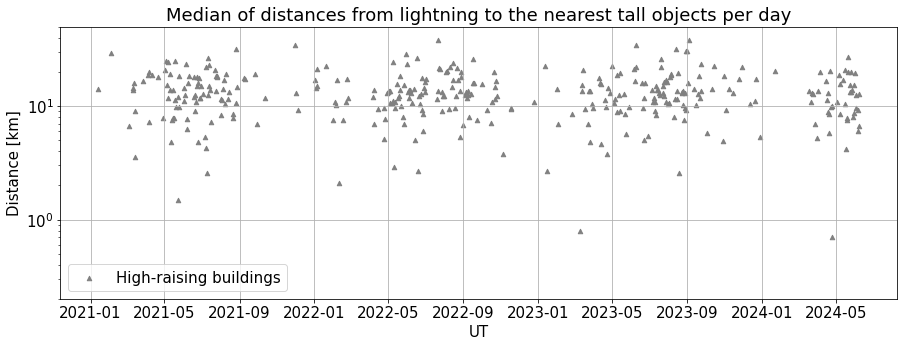

In [255]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_bu'], marker='^', color='grey', s=20, label='High-raising buildings')
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.ylim(0.2, 50)
plt.legend(loc=3)
plt.title('Median of distances from lightning to the nearest tall objects per day')
plt.grid()

plt.savefig("/home/kakl/vanice/pics/fig_medians_tall.png", format="png", dpi=600, bbox_inches="tight")   
plt.show()


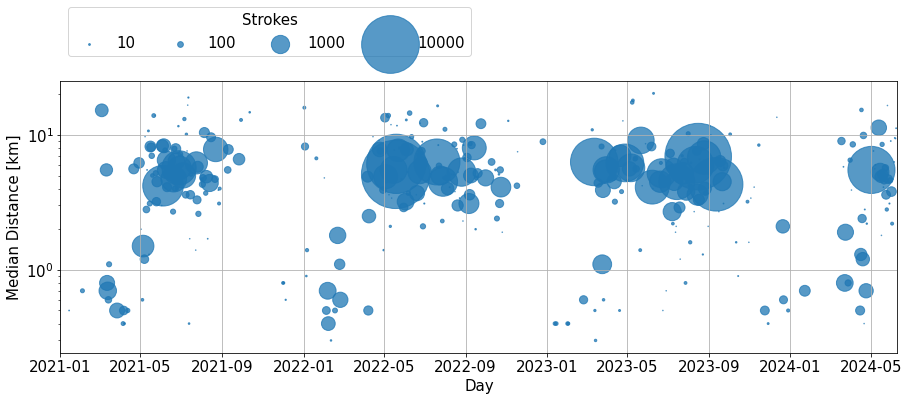

In [266]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_wt'], color='C0', s=medians['strokes']/3, alpha=0.75)
plt.scatter(pd.to_datetime('2020-01-01'),1, label='10', s=10/3, color='C0', alpha=0.75)
plt.scatter(pd.to_datetime('2020-01-01'),2, label='100', s=100/3, color='C0', alpha=0.75)
plt.scatter(pd.to_datetime('2020-01-01'),3, label='1000', s=1000/3, color='C0', alpha=0.75)
plt.scatter(pd.to_datetime('2020-01-01'),4, label='10000', s=10000/3, color='C0', alpha=0.75)
plt.ylabel('Median Distance [km]')
plt.xlabel('Day')
plt.yscale('log')
plt.xlim(pd.to_datetime('2021-01-01'),pd.to_datetime('2024-06-10'))
plt.legend( title='Strokes', ncol=4, bbox_to_anchor=(0, 1.3), loc="upper left")
#plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

plt.savefig("/home/kakl/vanice/pics/fig_strokes.png", format="png", dpi=600, bbox_inches="tight")   
plt.show()


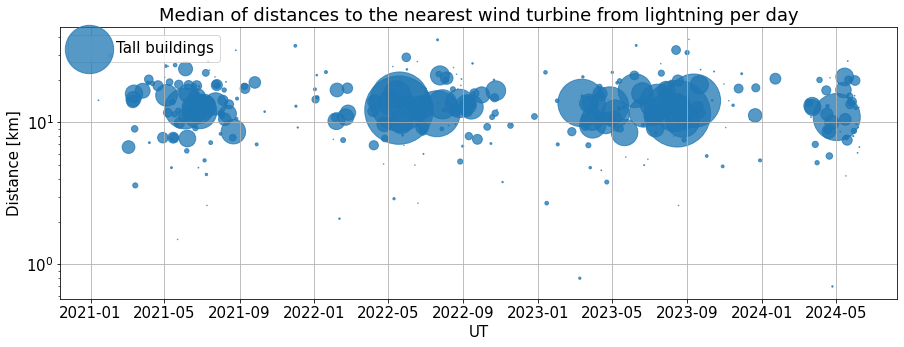

In [71]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_bu'], label='Tall buildings', s=medians['strokes']/3, alpha=0.75)
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.legend(loc=2)
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

In [206]:
medians.to_csv('medians_2021-2024.csv')

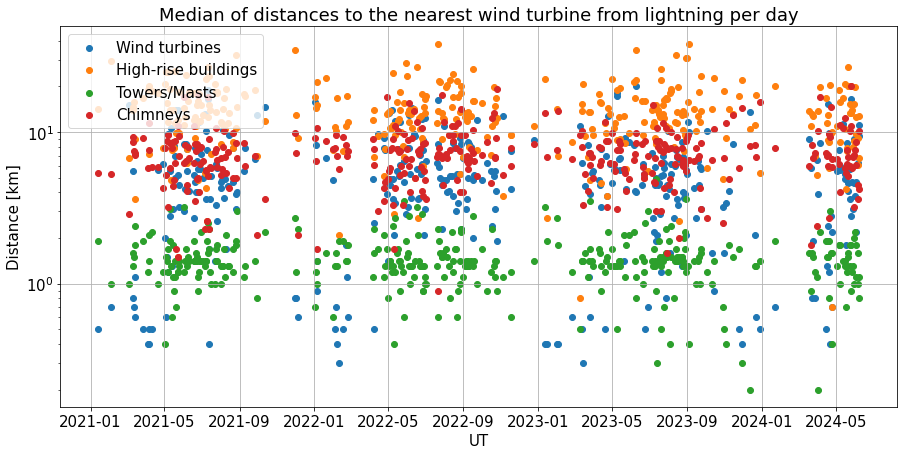

In [78]:
plt.figure(figsize=(15,7))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_wt'], label='Wind turbines')
plt.scatter(medians['day'],medians['median_bu'], label='High-rise buildings')
plt.scatter(medians['day'],medians['median_tw'], label='Towers/Masts')
plt.scatter(medians['day'],medians['median_ch'], label='Chimneys')
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.legend(loc=2)
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

# Random Lightning

In [267]:
# Generate random lightning
# set random azimuth angles (seed for reproducablity)
npoints = 1000
np.random.seed(1235)
rand_azimuths_deg = np.random.random(npoints)*360

# set random distances (seed for reproducablity)
np.random.seed(6341)
rand_distances = BLITZ_DIST*1000*np.sqrt((np.random.random(npoints))) # np.random.uniform(low=0, high=radius, size=npoints)

blitz = pd.DataFrame(columns=['lat', 'lon'])
blitz.lon = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,0]
blitz.lat = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,1]


In [268]:
# Reduction of distant lightnings

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)


In [269]:
# Identify lightning with nearby structures

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_windturbines = windturbines['latRad'].to_numpy()
lonRad_windturbines = windturbines['lonRad'].to_numpy()
latRad_towers = towers['latRad'].to_numpy()
lonRad_towers = towers['lonRad'].to_numpy()
latRad_masts = masts['latRad'].to_numpy()
lonRad_masts = masts['lonRad'].to_numpy()
latRad_chimneys = chimneys['latRad'].to_numpy()
lonRad_chimneys = chimneys['lonRad'].to_numpy()
latRad_buildings = buildings['latRad'].to_numpy()
lonRad_buildings = buildings['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_wt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_windturbines, lonRad_windturbines)
distances_tw = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_towers, lonRad_towers)
distances_mt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_masts, lonRad_masts)
distances_ch = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_chimneys, lonRad_chimneys)
distances_bu = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_buildings, lonRad_buildings)


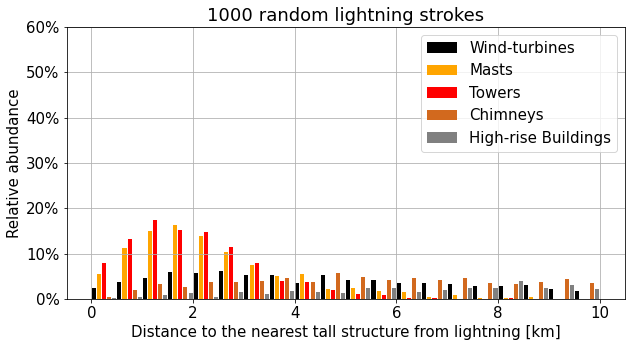

In [270]:
celkem = len(blitz)

#plt.figure(figsize=(10,5), facecolor='lightyellow')
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 15})
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

BINS = 20

#plt.hist(np.amin(distances_wt,axis=1), bins=50)
#plt.hist((np.amin(distances_wt, axis=1),np.amin(distances_mt, axis=1),np.amin(distances_tw, axis=1)),color=('orange','purple','red'),edgecolor='white',label=('wind-turbines','masts','towers'),bins=np.linspace(0, 10, 40))
hh1 = np.histogram(np.amin(distances_wt, axis=1), bins= np.linspace(0, 10, BINS+1))
hh2 = np.histogram(np.amin(distances_mt, axis=1), bins= np.linspace(0, 10, BINS+1))
hh3 = np.histogram(np.amin(distances_tw, axis=1), bins= np.linspace(0, 10, BINS+1))
hh4 = np.histogram(np.amin(distances_ch, axis=1), bins= np.linspace(0, 10, BINS+1))
hh5 = np.histogram(np.amin(distances_bu, axis=1), bins= np.linspace(0, 10, BINS+1))
#plt.hist((np.amin(distances_wt, axis=1),np.amin(distances_mt, axis=1),np.amin(distances_tw, axis=1)),color=('black','orange','red'),edgecolor='white',label=('wind-turbines','masts','towers'),bins=np.linspace(0, 10, 40),density=True)
plt.ylim(0,0.6)
plt.bar(hh1[1][:-1]+0.05,hh1[0]/celkem, width=0.08, label='Wind-turbines', color='black')
plt.bar(hh2[1][:-1]+0.05+0.1,hh2[0]/celkem, width=0.08, label='Masts', color='orange')
plt.bar(hh3[1][:-1]+0.05+2*0.1,hh3[0]/celkem, width=0.08, label='Towers', color='red')
plt.bar(hh4[1][:-1]+0.05+3*0.1,hh4[0]/celkem, width=0.08, label='Chimneys', color='chocolate')
plt.bar(hh5[1][:-1]+0.05+4*0.1,hh5[0]/celkem, width=0.08, label='High-rise Buildings', color='gray')
plt.legend()
plt.xlabel('Distance to the nearest tall structure from lightning [km]')
plt.ylabel('Relative abundance')
plt.title(str(npoints) + ' random lightning strokes')
plt.grid()

# Lightning distribution

In [378]:
# Load of lightning data
filename = '/storage/blitzortung/2021-2023/region-1/2021-03-12.log'
filename = '/storage/blitzortung/2021-2023/region-1/2021-03-13.log'
#filename = '/storage/blitzortung/2021-2023/region-1/2022-06-24.log'
#filename = '/storage/blitzortung/2021-2023/region-1/2022-02-07.log'
#filename = '/storage/blitzortung/2021-2023/region-1/2023-07-28.log'
#filename = '/storage/blitzortung/2021-2023/region-1/2023-03-25.log'
filename = '/storage/blitzortung/2021-2023/region-1/2022-07-20.log'

blitz = pd.read_csv(filename, sep=',', low_memory=False, on_bad_lines='skip')


In [377]:
medians['2022-07-20':]


Unnamed: 0        day  median  median_wt  median_tw  median_ch  \
day                                                                          
2022-07-20           0 2022-07-20     NaN        6.3        1.3        6.8   
2022-07-21           0 2022-07-21     NaN       16.4        0.6        0.9   
2022-07-22           0 2022-07-22     NaN        8.4        2.3        7.2   
2022-07-23           0 2022-07-23     NaN        5.9        1.9        7.8   
2022-07-24           0 2022-07-24     NaN        NaN        NaN        NaN   
...                ...        ...     ...        ...        ...        ...   
2024-06-04           0 2024-06-04     NaN        NaN        NaN        NaN   
2024-06-05           0 2024-06-05     NaN        6.3        1.6        3.6   
2024-06-06           0 2024-06-06     NaN        9.5        1.0        4.5   
2024-06-07           0 2024-06-07     NaN        9.4        1.1       10.1   
2024-06-08           0 2024-06-08     NaN       11.2        0.8        4.2   

            median_bu  strokes  
day                             
2022-07-20       11.5   6346.0  
2022-07-21       38.1     12.0  
2022-07-22       13.7      3.0  
2022-07-23       21.9     94.0  
2022-07-24        NaN      0.0  
...               ...      ...  
2024-06-04        NaN      0.0  
2024-06-05        6.1      2.0  
2024-06-06        9.2      2.0  
2024-06-07       12.7      2.0  
2024-06-08        6.7      2.0  

[690 rows x 8 columns]

In [379]:
# Reduction of distant lightnings

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)


In [380]:
# Identify lightning with nearby structures

# Converting pandas.Series to numpy.array
latRad_blitz = blitz['latRad'].to_numpy()
lonRad_blitz = blitz['lonRad'].to_numpy()
latRad_windturbines = windturbines['latRad'].to_numpy()
lonRad_windturbines = windturbines['lonRad'].to_numpy()
latRad_towers = towers['latRad'].to_numpy()
lonRad_towers = towers['lonRad'].to_numpy()
latRad_masts = masts['latRad'].to_numpy()
lonRad_masts = masts['lonRad'].to_numpy()
latRad_chimneys = chimneys['latRad'].to_numpy()
lonRad_chimneys = chimneys['lonRad'].to_numpy()
latRad_buildings = buildings['latRad'].to_numpy()
lonRad_buildings = buildings['lonRad'].to_numpy()

# Calculating distance between each point in 'blitz' and all points in 'structures'
distances_wt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_windturbines, lonRad_windturbines)
distances_tw = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_towers, lonRad_towers)
distances_mt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_masts, lonRad_masts)
distances_ch = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_chimneys, lonRad_chimneys)
distances_bu = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_buildings, lonRad_buildings)


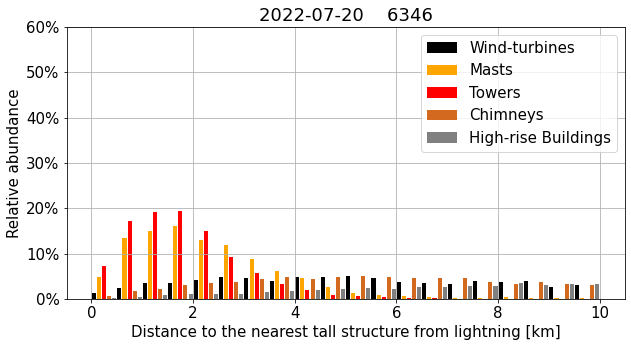

In [381]:
celkem = len(blitz)

#plt.figure(figsize=(10,5), facecolor='lightyellow')
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 15})
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

BINS = 20

#plt.hist(np.amin(distances_wt,axis=1), bins=50)
#plt.hist((np.amin(distances_wt, axis=1),np.amin(distances_mt, axis=1),np.amin(distances_tw, axis=1)),color=('orange','purple','red'),edgecolor='white',label=('wind-turbines','masts','towers'),bins=np.linspace(0, 10, 40))
hh1 = np.histogram(np.amin(distances_wt, axis=1), bins= np.linspace(0, 10, BINS+1))
hh2 = np.histogram(np.amin(distances_mt, axis=1), bins= np.linspace(0, 10, BINS+1))
hh3 = np.histogram(np.amin(distances_tw, axis=1), bins= np.linspace(0, 10, BINS+1))
hh4 = np.histogram(np.amin(distances_ch, axis=1), bins= np.linspace(0, 10, BINS+1))
hh5 = np.histogram(np.amin(distances_bu, axis=1), bins= np.linspace(0, 10, BINS+1))
#plt.hist((np.amin(distances_wt, axis=1),np.amin(distances_mt, axis=1),np.amin(distances_tw, axis=1)),color=('black','orange','red'),edgecolor='white',label=('wind-turbines','masts','towers'),bins=np.linspace(0, 10, 40),density=True)
plt.ylim(0,0.6)
plt.bar(hh1[1][:-1]+0.05,hh1[0]/celkem, width=0.08, label='Wind-turbines', color='black')
plt.bar(hh2[1][:-1]+0.05+0.1,hh2[0]/celkem, width=0.08, label='Masts', color='orange')
plt.bar(hh3[1][:-1]+0.05+2*0.1,hh3[0]/celkem, width=0.08, label='Towers', color='red')
plt.bar(hh4[1][:-1]+0.05+3*0.1,hh4[0]/celkem, width=0.08, label='Chimneys', color='chocolate')
plt.bar(hh5[1][:-1]+0.05+4*0.1,hh5[0]/celkem, width=0.08, label='High-rise Buildings', color='gray')
plt.legend()
plt.xlabel('Distance to the nearest tall structure from lightning [km]')
plt.ylabel('Relative abundance')
plt.title(filename.split('/')[-1].split('.')[0] + '    ' + str(celkem))
plt.grid()
plt.savefig("/home/kakl/vanice/pics/fig_"+filename.split('/')[-1].split('.')[0], format="png", dpi=600, bbox_inches="tight")   
plt.show()


# Animace

In [382]:
radius_error = 1.4

# Load of lightning data
filename = '/storage/blitzortung/2021-2023/region-1/2021-03-12.log'
filename = '/storage/blitzortung/2021-2023/region-1/2021-03-13.log'
filename = '/storage/blitzortung/2021-2023/region-1/2022-06-24.log'
#filename = '/storage/blitzortung/2021-2023/region-1/2022-02-07.log'
#filename = '/storage/blitzortung/2021-2023/region-1/2023-07-28.log'
#filename = '/storage/blitzortung/2021-2023/region-1/2023-03-25.log'
filename = '/storage/blitzortung/2021-2023/region-1/2022-07-20.log'

blitz = pd.read_csv(filename, sep=',', low_memory=False, on_bad_lines='skip')


In [383]:
# Reduction of distant lightnings

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)


In [384]:
blitz['time'] = pd.to_datetime(blitz['time'])
blitz['time'] = blitz['time'].dt.round("1s")
maska = blitz['time'].diff().ne(pd.Timedelta(seconds=0))
# Vytvoření nového indexu
blitz['novy_index'] = maska.cumsum() - 1
blitz.set_index('novy_index',inplace=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

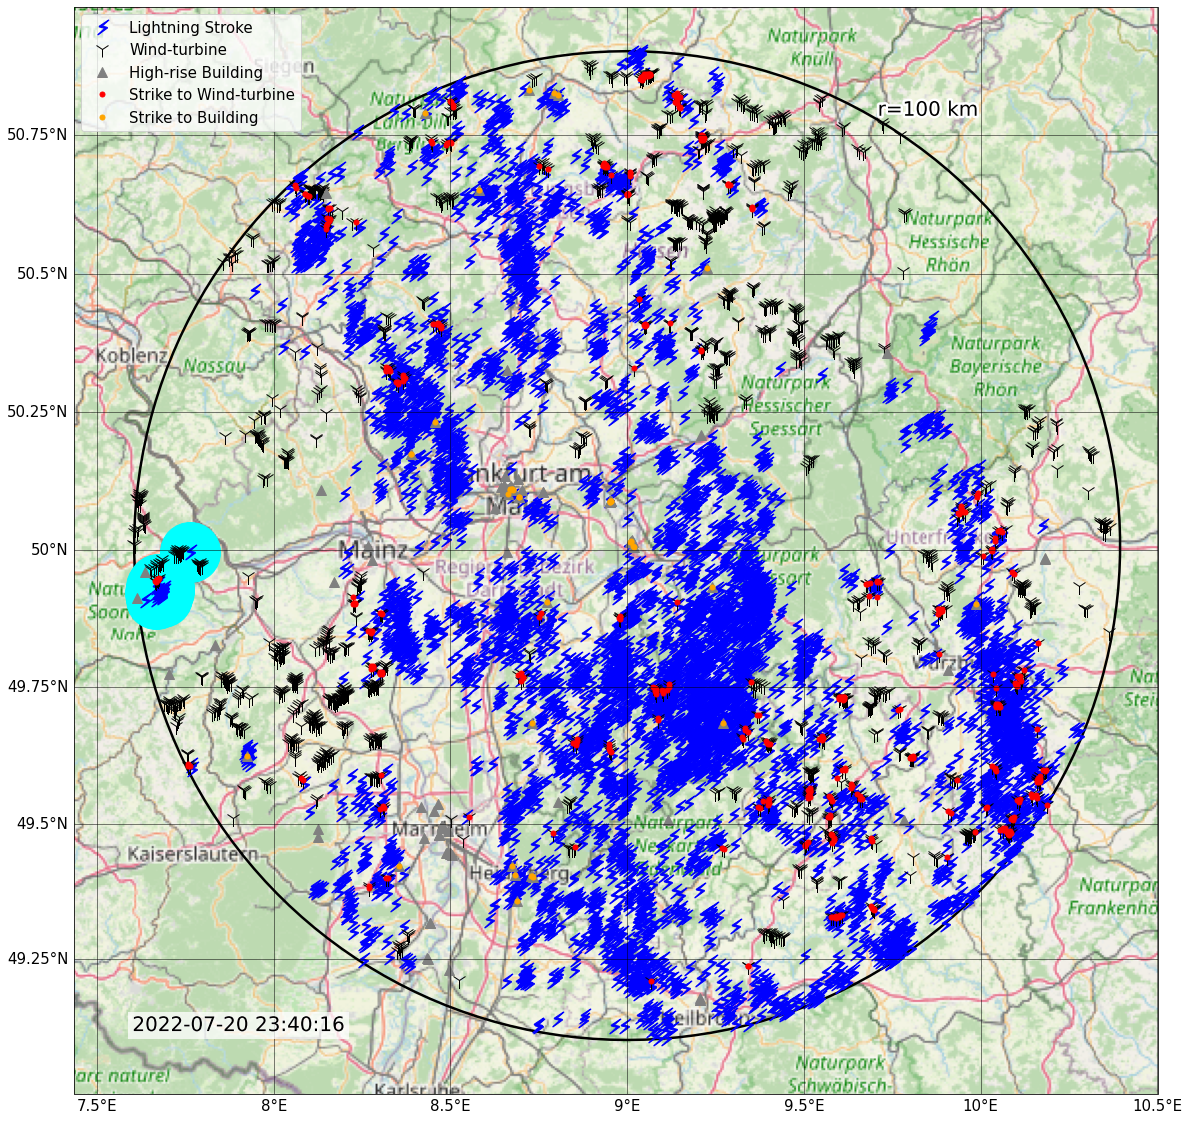

In [385]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    RADIUS = BLITZ_DIST * 1000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    for i in range(0,max(blitz.index)):
        bl = blitz.loc[blitz.index<=i]
        print(i)
        osm_image(bl,i,lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(bl,i,lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    #ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    scale = 8
    
    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    #ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    #ax.plot(lon,lat, color='black', marker='x', ms=11, mew=2, transform=data_crs)
    
    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    #lightning = blitz.loc['2023-07-06 11:30':'2023-07-06 11:40']
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u21AF$',ms=25,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$\u26A1$',ms=35,mew=1.0,transform=data_crs)
    ax.plot(bl.loc[bl.index==i].lon,bl.loc[bl.index==i].lat,color='cyan',lw=0,marker='o',ms=60,mew=1.0,transform=data_crs)
    ax.plot(bl.lon,bl.lat,color='blue',lw=0,marker='$\u26A1$',ms=15,mew=1.0,transform=data_crs, label='Lightning Stroke')

    t = ax.text(7.6, 49.11, str(bl.iloc[-1].time), color='black', fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)
    t.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0))

    ax.plot(windturbines.lon,windturbines.lat,color='black',lw=0,marker='1',ms=15,mew=1.0,transform=data_crs, label='Wind-turbine')
    ax.plot(buildings.lon,buildings.lat,color='gray',lw=0,marker='^',ms=10,mew=1.0,transform=data_crs, label='High-rise Building')
    #ax.plot(windturbines.lon,windturbines.lat,color='darkorange',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs)
    #ax.plot(windturbines.lon,windturbines.lat,color='black',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs)
    #ax.plot(wind_mills['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0]),wind_mills['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1]) ,color='darkorange',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs)

    # Identify lightning with nearby structures

    bl = bl.copy()
    # Converting coordinates to radians
    bl['latRad'] = np.radians(bl['lat'])
    bl['lonRad'] = np.radians(bl['lon'])

    # Converting pandas.Series to numpy.array
    latRad_blitz = bl['latRad'].to_numpy()
    lonRad_blitz = bl['lonRad'].to_numpy()

    # Calculating distance between each point in 'blitz' and all points in 'structures'
    distances = vec_haversine(latRad_windturbines[:, np.newaxis], lonRad_windturbines[:, np.newaxis],
                              latRad_blitz, lonRad_blitz)
    # Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
    windturbines['is_close'] = np.any(distances <= (radius_error), axis=1)    
    ax.plot(windturbines.loc[ windturbines['is_close']].lon,windturbines.loc[ windturbines['is_close']].lat,color='red',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs, label='Strike to Wind-turbine')
    

    # Calculating distance between each point in 'blitz' and all points in 'structures'
    distances = vec_haversine(latRad_buildings[:, np.newaxis], lonRad_buildings[:, np.newaxis],
                              latRad_blitz, lonRad_blitz)
    # Marking points in 'blitz' that are within 1.4 km of any point in 'structures'
    buildings['is_close'] = np.any(distances <= (radius_error), axis=1)    
    ax.plot(buildings.loc[buildings['is_close']].lon,buildings.loc[buildings['is_close']].lat,color='orange',lw=0,marker='o',ms=5,mew=1.0,transform=data_crs, label='Strike to Building')
    
    
    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={int(radius/1000)} km', color='black', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.legend(loc=2)

    #plt.show()

    #fig.savefig(f'./animation/'+str(i)+'.png', dpi=150, bbox_inches='tight')
    fig.savefig(f'/storage/experiments/2024/vetrniky/animation/'+str(i)+'.png', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

In [387]:
import cv2

img = cv2.imread('/storage/experiments/2024/vetrniky/animation/0.png')
print(img.shape)

# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
#video = cv2.VideoWriter('./animation/video.mp4', fourcc, 1.0, (2440, 2372))
video = cv2.VideoWriter('/storage/experiments/2024/vetrniky/animation/video.mp4', fourcc, 1.0, (img.shape[1], img.shape[0]))
print(video.isOpened())

#for j in range(0,88):
for j in range(0,971):
    f = '/storage/experiments/2024/vetrniky/animation/'+ str(j) + '.png'
    img = cv2.imread(f)
    video.write(img)

#cv2.destroyAllWindows()
video.release()
print('end')

(2336, 2479, 3)
True
end


In [361]:
img

In [349]:
blitz.loc[blitz['time']=='2021-03-13 16:28:23']

index                time        lat       lon    lonRad  \
novy_index                                                             
34           8087 2021-03-13 16:28:23  50.161027  8.655082  0.151060   
34           8088 2021-03-13 16:28:23  50.158842  8.651480  0.150997   
34           8089 2021-03-13 16:28:23  50.153401  8.648348  0.150942   
34           8090 2021-03-13 16:28:23  50.148035  8.646157  0.150904   
34           8091 2021-03-13 16:28:23  50.135431  8.656655  0.151087   
34           8092 2021-03-13 16:28:23  50.164861  8.666061  0.151251   

              latRad   DlonRad   DlatRad         a         km  
novy_index                                                     
34          0.875475  0.006020 -0.002810  0.000006  30.469125  
34          0.875437  0.006083 -0.002772  0.000006  30.536545  
34          0.875342  0.006137 -0.002677  0.000006  30.375824  
34          0.875248  0.006176 -0.002584  0.000006  30.176277  
34          0.875028  0.005993 -0.002364  0.000005  28.794732  
34          0.875542  0.005828 -0.002877  0.000006  30.096069